### RNG and (width, height) distributions

In [1]:
import numpy as np
from numpy.random._generator import Generator
import functools
from SquareDivision.src.distributions import x_plus_y_func
from SquareDivision.config import config

rng:Generator = np.random.default_rng(config['seed'])
func = functools.partial(x_plus_y_func, 
                         min_00=0.025, max_00=0.03,
                         min_11=0.2, max_11=0.3,
                         rng=rng)

### Picking random rectangles and inflating them

In [2]:
from SquareDivision.src.generators import uniform_pts
from SquareDivision.src.dataflow import arg_rect_list, process

rng:Generator = np.random.default_rng(config['seed'])
arr = arg_rect_list(10, uniform_pts, func, rng=rng)
arr, pushed_arr = process(arr)

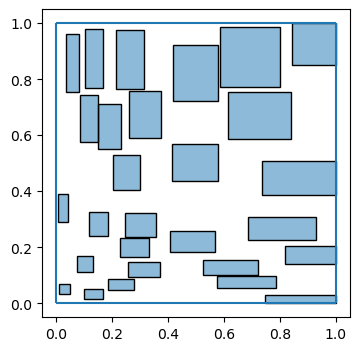

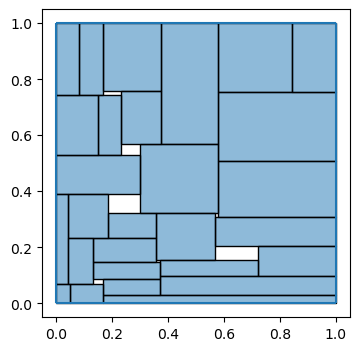

In [3]:
import matplotlib.pyplot as plt
from SquareDivision.src.draw import draw_rectangles, set_settings#, draw_suspended_walls
from SquareDivision.src.regions import opposing_walls_in_half_plane_in_dir

suspect, direction = 5, 'u'
which_list, sus_walls = opposing_walls_in_half_plane_in_dir(suspect, arr, direction)

fig, ax = plt.subplots()
fig, ax = set_settings(fig, ax)
ax = draw_rectangles(ax, arr) #, False)
# ax = draw_suspended_walls(ax, direction, sus_walls)
plt.show()

fig, ax = plt.subplots()
fig, ax = set_settings(fig, ax)
ax = draw_rectangles(ax, pushed_arr)#, False)
# ax = draw_suspended_walls(ax, direction, sus_walls)
plt.show()

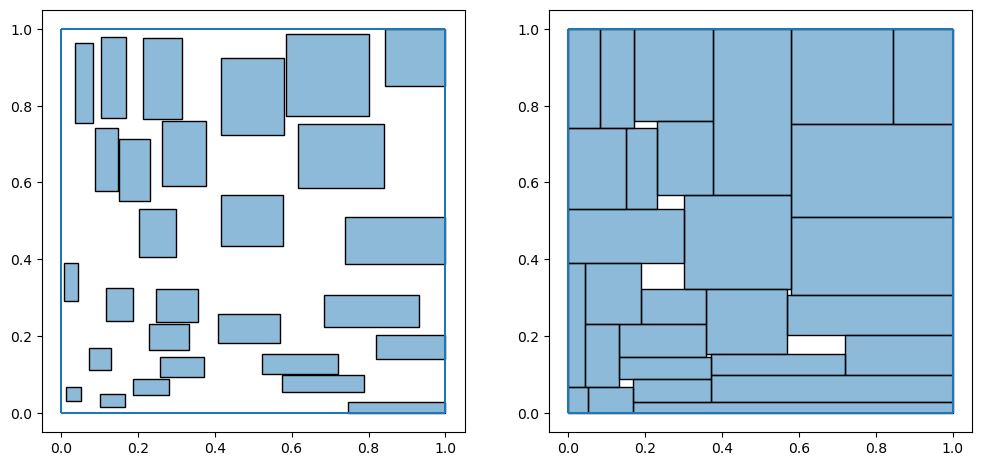

In [3]:
import matplotlib.pyplot as plt
from SquareDivision.src.draw import draw_rectangles

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0] = draw_rectangles(axes[0], arr)
axes[1] = draw_rectangles(axes[1], pushed_arr)
plt.show()

### Projection onto retrangulation without holes

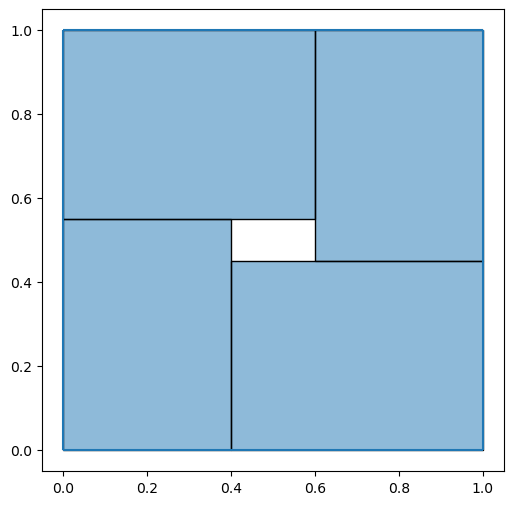

In [48]:
width, height = np.array([0.2, 0.1]) / 2
rect_area = (0.5 - width)*(0.5 + height)
arr_with_hole = np.array([
    [          0,            0, 0.5 - width, 0.5 + height, rect_area],
    [          0, 0.5 + height, 0.5 + width, 0.5 - height, rect_area],
    [0.5 + width, 0.5 - height, 0.5 - width, 0.5 + height, rect_area],
    [0.5 - width,            0, 0.5 + width, 0.5 - height, rect_area],
])

fig, ax = plt.subplots(figsize=(6, 6))
ax = draw_rectangles(ax, arr_with_hole)
plt.show()

### condition will be `[x, y, width, height, area]` such that:
sum of areas is 1, apropriate sums of height and width are 1, first build matrix `A`

In [82]:
east_neighbours = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0]
])
north_neighbours = np.array([
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0]
])
def build_A_and_rhs(arr, east_neighbours:np.ndarray):
    """ Builds stack matricies for matrix equation (id - A) . X = rhs
            -----------------------------------------------------------------------------------------
            :   | id_lower   |     |    0       |       |           |           ...             |   :
            : ( | id_upper   |  -  |    0       | ).dot(|   Flatten(| x_i, y_i, w_i, h_i, ar_i  |)  :  
            :   | id_contact |     | A_contanct |       |           |           ...             |   :
            :       | 0 if rect on lower boundary  |                                                :
            :   ==  | 1 if rect on upper boundary  |                                                :
            :       | 0                            |                                                :
            -----------------------------------------------------------------------------------------
        The above repre4sents set oe equalities:
            (id_lower)  :   for those on the left boundary
                x_i == 0
            (id_upper)  :   for those on the right boundary
                x_j + w_j == 1
            (id_contact):   for those rects which are upper neighbour of single contact e.g. index k
            (A_contanct):   for those rects which are lower neighbour of single contact e.g. index i
                x_k = x_i + w_i

        """
    n, m = len(arr), np.sum(east_neighbours)
    id_lower   = np.zeros(shape=(5*n, 5*n))
    id_upper   = np.zeros(shape=(5*n, 5*n))
    id_contact = np.zeros(shape=(m, 5*n))
    zeros_of_A = np.zeros(shape=(5*n, 5*n))

    A_contanct = np.zeros(shape=(m, 5*n))
    rhs = np.zeros(shape=(2*(5*n) + m,))

    # first fill id_lower and id_upper for representation of 
    # x_i == 0 and x_j + w_j == 1 respectively
    for rect_num in range(n):
        if np.sum(east_neighbours.T[rect_num]) == 0:
            # rectangle is not an east neighbour of any other rectangle => it is on lower boundary
            id_lower[5*rect_num, 5*rect_num + 0] = 1
        if np.sum(east_neighbours[rect_num]) == 0:
            # rectangle has no east neighbours => it is on upper boundary
            id_upper[5*rect_num, 5*rect_num + 0], id_upper[5*rect_num, 5*rect_num + 0 + 2] = 1, 1
            rhs[(5*n) + 5*rect_num + 0] = 1
    
    # now for contacts:
    for contact_num, (num_low_neighb, num_hig_neighb) in enumerate(zip(*np.where(east_neighbours > 0))):
        id_contact[contact_num, 5*num_low_neighb + 0] = 1
        A_contanct[contact_num, 5*num_hig_neighb + 0] = 1
        A_contanct[contact_num, 5*num_hig_neighb + 2] = 1
    id_stack    = np.r_[id_lower,     id_upper, id_contact]
    A_stack     = np.r_[zeros_of_A, zeros_of_A, A_contanct]
    return id_stack, A_stack, rhs


In [83]:
id_stack, A_stack, rhs =  build_A_and_rhs(arr_with_hole, east_neighbours)
print(id_stack.astype(int)[20:40])
rhs.astype(int)[20:40]

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])